TFRecord是google的一種檔案格式，主要是將資料轉為binary格式之後保存，方便攜帶，或許可以視為一種序列化的方式，就google的立場，當然是希望可以主用這種格式，不過比較建議在大數據的情況下再使用吧，至於什麼是大數據，大概就是你處理起資料來loading變的很重很重，主機無法負荷就當做你擁有大數據了。

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
tf.__version__

'2.1.0'

In [3]:
import sys
sys.version

'3.6.9 (default, Nov  7 2019, 10:44:02) \n[GCC 8.3.0]'

指定硬體資源，相關可[參考](https://hackmd.io/@shaoeChen/ryWIV4vkL)

In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

In [5]:
gpus 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

In [7]:
tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)

原本的class就不要用了，讓它隨風去，一樣取得MNIST資料集並做標準化。

In [8]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train / 255., -1)
x_test = np.expand_dims(x_test / 255., -1)

In [9]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

TFRecord的組成很簡單，TFRecord由一系列的`tf.train.Example`所組成，而每一個`tf.train.Example`都由多個`tf.train.Feature`的key-value格式所組成

```shell
# dataset.tfrecords
[
    {   # example 1 (tf.train.Example)
        'feature_1': tf.train.Feature,
        ...
        'feature_k': tf.train.Feature
    },
    ...
    {   # example N (tf.train.Example)
        'feature_1': tf.train.Feature,
        ...
        'feature_k': tf.train.Feature
    }
]
```

在將資料轉TFRecord的時候，大致流程如下：
1. 資料載入記憶體
2. 資料轉為`tf.train.Example`(記得`tf.train.Example`是由`tf.train.Feature`所組成)
3. 利用`tf.io.TFRecordWriter`寫入，生成TFRecord檔案

稍早已經將MNIST的資料寫入記憶體

將資料轉為`tf.train.Example`

In [10]:
# 設置tf.io.TFRecordWriter上下文，並指定檔案保存路徑
with tf.io.TFRecordWriter(path='./MNIST.tfrecords') as tf_writer:        
    for image, label in zip(x_train, y_train):
        # 以key-value方式設置feature
        feature = {
            # 無法直接轉ndarray，因此要將ndarry先轉為tensor，再轉為numpy，這時候是binary
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(image).numpy()])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))            
        }
        # example是由多個feature組成
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        # TFRecord由多個example組成
        tf_writer.write(example.SerializeToString())

沒意外的話，執行上面的程式碼應該可以在設置的資料夾內看到相對應的檔案，這代表我們成功了。

[參考來源_Working with TFRecords and tf.train.Example](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d)

在轉ndarry的部份，下面單純說明格式上的轉換

In [11]:
_abc = tf.io.serialize_tensor(x_train[0])
abc = _abc.numpy()
type(_abc), type(abc)

(tensorflow.python.framework.ops.EagerTensor, bytes)

成功轉回

In [12]:
tf.io.parse_tensor(abc, tf.float64).shape

TensorShape([28, 28, 1])

TFRecord以`feature`的方式來儲存，有三種格式：  
* `tf.train.BytesList`
    * string
    * byte
* `tf.train.FloatList`
    * float
    * double    
* `tf.train.Int64List`
    * bool
    * enum
    * int32
    * uint32
    * int64
    * uint64

一個檔案的傳輸與攜帶，總是比60000張照片與標籤帶著走還要來的方便，現在，假設我拿到朋友或同事給我的TFRecord檔案，該是讀取的時候了

In [13]:
# 如果你是python 2.7就執行下面這段
# np.frombuffer(abc, np.float32)

In [14]:
# 利用tf.data.TFRecordDataset來載入檔案
datasets_tfrecord = tf.data.TFRecordDataset('MNIST.tfrecords')

接下來要定義一個相對應寫入TFRecord的feature的key-value，也就是你的key與value type都要一致才行

In [15]:
feature_type = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

接著，設置一個function來parser資料

In [16]:
def parser_tfrecord(tfrecord_example):
    # 解析單筆的example，並提供feature type
    _feature = tf.io.parse_single_example(tfrecord_example, feature_type)
    # 不要忘了，目前的image是binary格式的資料，要轉回
    _feature['image'] = tf.io.parse_tensor(_feature['image'], tf.float64)
    return _feature['image'], _feature['label']

利用`tf.data.Dataset.map`來綁定函數與資料集

In [17]:
datasets = datasets_tfrecord.map(parser_tfrecord)

驗證資料正確性

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

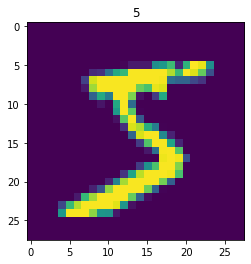

In [19]:
for image, label in datasets.take(1):
    plt.imshow(image.numpy()[:, :, 0])
    plt.title(label.numpy())

plt.show()

現在，我們可以試著用這個datasets來訓練模型了

利用標準的keras Sequential來建置模型

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='valid', activation='tanh'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='tanh'),
    tf.keras.layers.Dense(84, activation='tanh'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

確認模型

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

編譯模型

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

訓練模型

In [23]:
%%time
model.fit(datasets,
          epochs=5, 
          steps_per_epoch=int(len(x_train)/128))

ValueError: in converted code:

    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training_utils.py:526 standardize_input_data
        standardize_single_array(x, shape) for (x, shape) in zip(data, shapes)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training_utils.py:526 <listcomp>
        standardize_single_array(x, shape) for (x, shape) in zip(data, shapes)
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/engine/training_utils.py:451 standardize_single_array
        if (x.shape is not None and len(x.shape) == 1 and
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/tensor_shape.py:822 __len__
        raise ValueError("Cannot take the length of shape with unknown rank.")

    ValueError: Cannot take the length of shape with unknown rank.


看起來似乎有點問題，這部份也至tensorflow的git上發問，目前待解，如果有Python 3.7.3版本的可以測試看看。
https://github.com/tensorflow/tensorflow/issues/35358  

但是如果調整一下訓練的方式，改以`tf.GradientTape()`來訓練的話似乎又可以正常

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

In [25]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        # 計算feedforward得到output
        predictions = model(x)
        # 計算實際與模型output的loss
        loss = loss_object(y, predictions)
    
    # 計算可訓練參數對損失函數的梯度
    gradients = tape.gradient(loss, model.trainable_variables)
    # 利用得到的梯度來更新參數
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y, predictions)

In [26]:
datasets = datasets.batch(64)

In [27]:
for epoch in range(1):
    # 批次取資料迴圈    
    for x, y in datasets:
        train_step(x, y)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



這邊也另外發現到，如果兩次執行`tf.data.Dataset.batch`會造成維度上的怪異，不確定是正常還是不正常，也許是我想不到應用。

目前已經執行過一次，設置batch_size為64，先看一下資料維度

In [29]:
for x, y in datasets:
    print(x.shape)
    break

(64, 28, 28, 1)


再做一次

In [31]:
datasets = datasets.batch(64)

In [32]:
for x, y in datasets:
    print(x.shape)
    break

(64, 64, 28, 28, 1)


嘿，發現了嗎?維度變怪了。再一次就異常了。